**15장 – RNN과 CNN을 사용해 시퀀스 처리하기**

_이 노트북은 15장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지와 텐서플로 버전이 2.0 이상인지 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = "google.colab" in sys.modules

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os
from pathlib import Path

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 기본적인 RNN

## 데이터셋 생성

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   웨이브 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + 웨이브 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + 잡음
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

그림 저장 time_series_plot


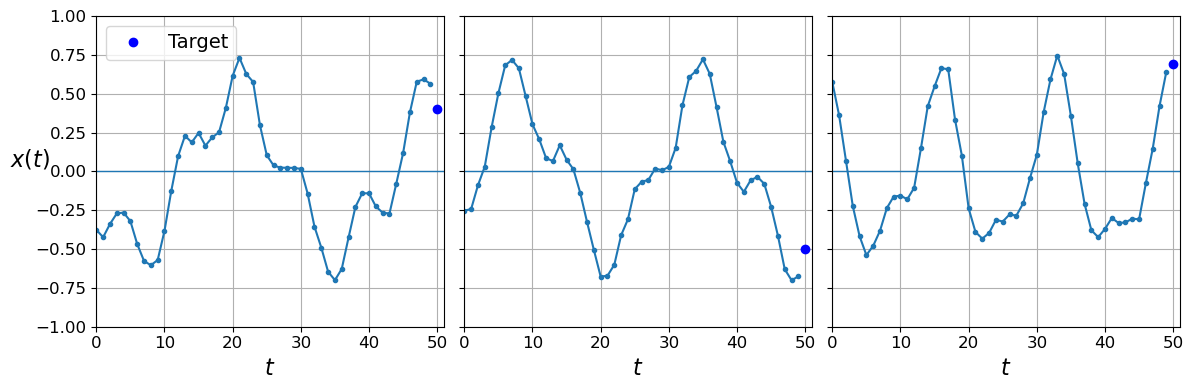

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

**노트**: 이 노트북에서 파란 점은 타깃을 나타내고 빨강 X 표시는 예측을 나타냅니다. 처음에 책에서 파란 X 표시를 타깃에 사용하고 빨강 점을 예측에 사용했다가 나중에 바꾸었습니다. 혼동을 드려 죄송합니다.

## 기준 성능 계산하기

단순한 예측 (마지막 관측값을 사용해 예측합니다):

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

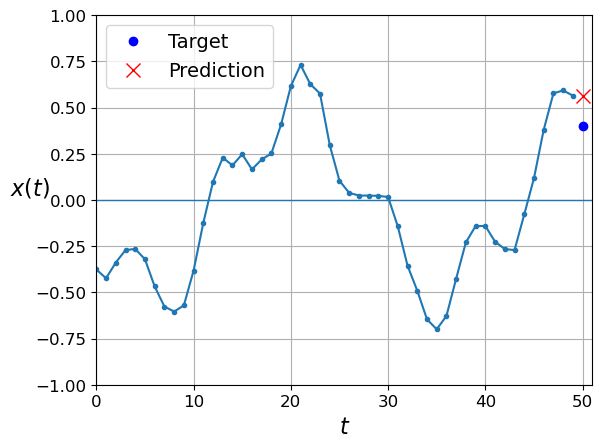

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

선형 예측:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 2ms/step - loss: 0.0758 - val_loss: 0.0271
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0181 - val_loss: 0.0130
Epoch 3/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0112 - val_loss: 0.0100
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 8/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0043

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0035


0.0034850998781621456

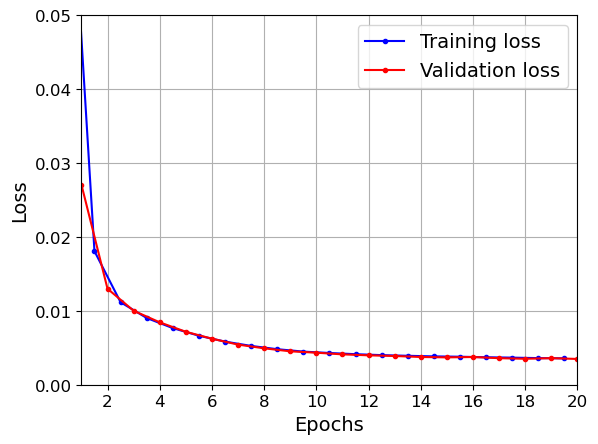

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 985us/step


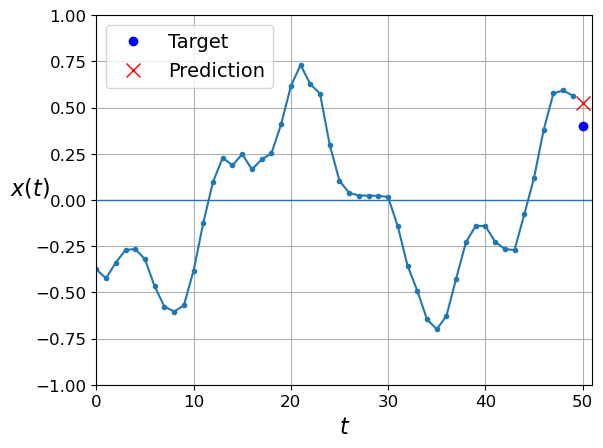

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 간단한 RNN 사용하기

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 12s 54ms/step - loss: 0.3451 - val_loss: 0.2492
Epoch 2/20
219/219 [==============================] - 12s 57ms/step - loss: 0.1663 - val_loss: 0.1184
Epoch 3/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0743 - val_loss: 0.0457
Epoch 4/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0282 - val_loss: 0.0182
Epoch 5/20
219/219 [==============================] - 12s 57ms/step - loss: 0.0141 - val_loss: 0.0120
Epoch 6/20
219/219 [==============================] - 12s 56ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 7/20
219/219 [==============================] - 12s 56ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 13s 58ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 9/20
219/219 [==============================] - 13s 57ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 10/20
219/219 [==============================] - 13s 57ms/step - loss: 0.011

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 15ms/step - loss: 0.0109


0.010874311439692974

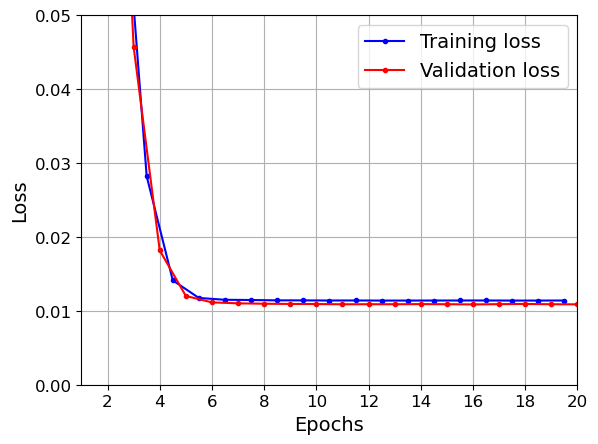

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 14ms/step


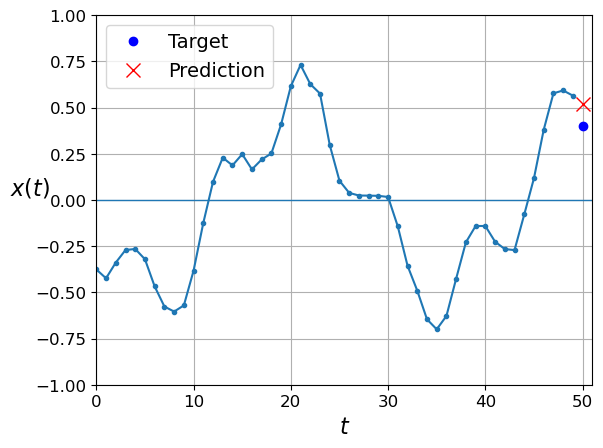

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 심층 RNN

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 47s 211ms/step - loss: 0.0551 - val_loss: 0.0065
Epoch 2/20
219/219 [==============================] - 45s 204ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 3/20
219/219 [==============================] - 47s 214ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 4/20
219/219 [==============================] - 51s 232ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 5/20
219/219 [==============================] - 45s 205ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 6/20
219/219 [==============================] - 45s 206ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 7/20
219/219 [==============================] - 45s 205ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 42s 194ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 9/20
219/219 [==============================] - 41s 189ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 10/20
219/219 [==============================] - 41s 186ms/step - l

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 3s 42ms/step - loss: 0.0028


0.002842638408765197

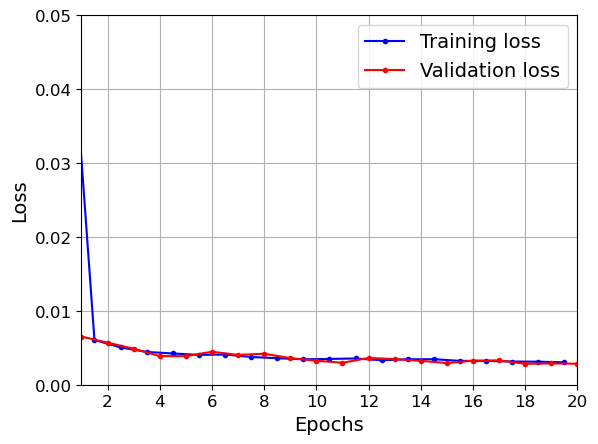

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 3s 41ms/step


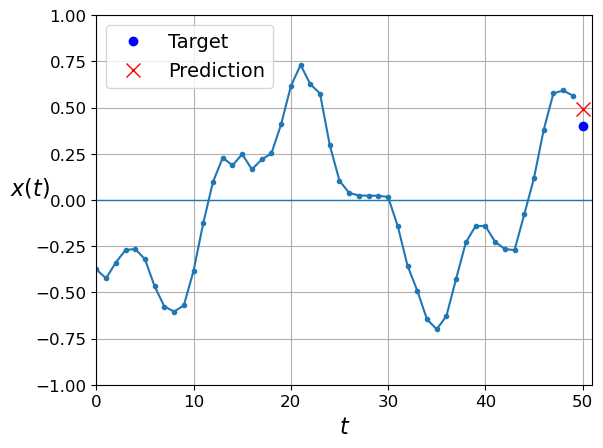

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

두 번째 `SimpleRNN` 층은 마지막 출력만 반환합니다:

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 28s 122ms/step - loss: 0.0130 - val_loss: 0.0038
Epoch 2/20
219/219 [==============================] - 26s 120ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 3/20
219/219 [==============================] - 26s 121ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 26s 120ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 5/20
219/219 [==============================] - 26s 120ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 6/20
219/219 [==============================] - 26s 120ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 7/20
219/219 [==============================] - 26s 121ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 8/20
219/219 [==============================] - 27s 121ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 9/20
219/219 [==============================] - 26s 118ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/20
219/219 [==============================] - 27s 125ms/step - l

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 2s 28ms/step - loss: 0.0025


0.0025312716607004404

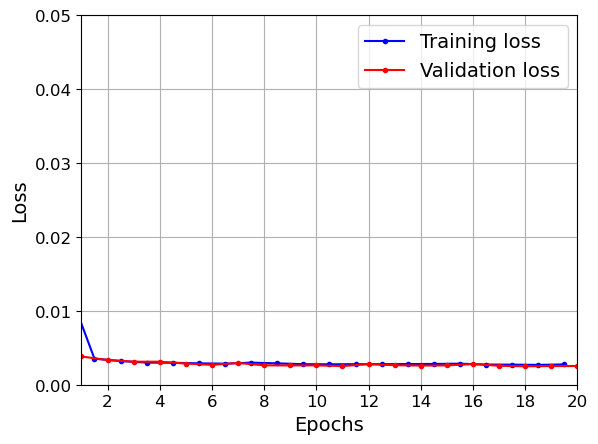

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 2s 27ms/step


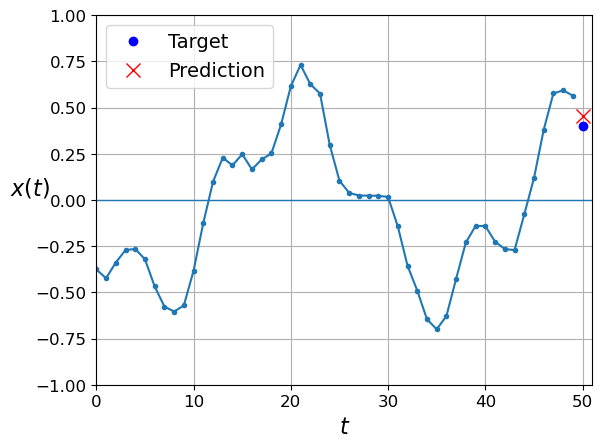

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 여러 타임 스텝 앞을 예측하기

In [24]:
np.random.seed(43) # 42는 훈련 세트에 있는 첫 번째 시리즈를 반환하기 때문에 다른 값으로 지정합니다

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 22ms/step


In [25]:
Y_pred.shape

(1, 10, 1)

그림 저장 forecast_ahead_plot


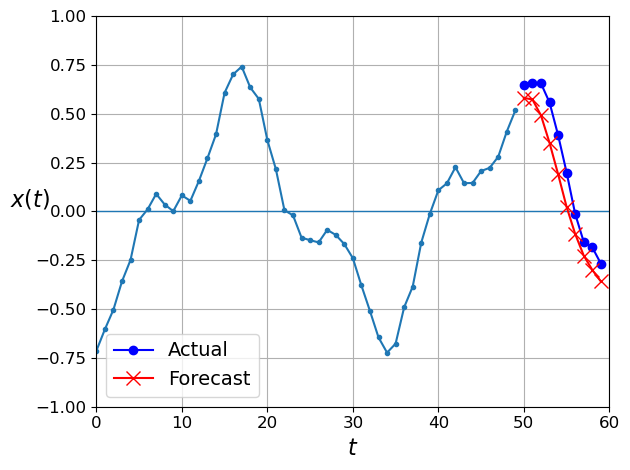

In [26]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

이 모델을 사용해 다음 10개의 값을 예측해 보겠습니다. 먼저 아홉 개의 타임 스텝을 더 가진 시퀀스를 다시 생성해야 합니다.

In [27]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

이제 하나씩 다음 10개의 값을 예측합니다:

In [28]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 2s 31ms/step


In [29]:
Y_pred.shape

(2000, 10)

In [30]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.020100461

이 성능을 단순한 예측이나 간단한 선형 모델과 비교해 보죠:

In [31]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # 마지막 타임 스텝 값을 선택해 10번 반복합니다
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1611 - val_loss: 0.0746
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0581 - val_loss: 0.0479
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0423 - val_loss: 0.0384
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0358 - val_loss: 0.0335
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0320 - val_loss: 0.0304
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0293 - val_loss: 0.0283
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0274 - val_loss: 0.0266
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0260 - val_loss: 0.0252
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0249 - val_loss: 0.0243
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0240 - val_loss: 0.0235

이제 동시에 다음 10개의 값을 모두 예측하는 RNN을 만들어 보겠습니다:

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 28s 123ms/step - loss: 0.0492 - val_loss: 0.0221
Epoch 2/20
219/219 [==============================] - 27s 121ms/step - loss: 0.0191 - val_loss: 0.0149
Epoch 3/20
219/219 [==============================] - 25s 115ms/step - loss: 0.0152 - val_loss: 0.0141
Epoch 4/20
219/219 [==============================] - 26s 119ms/step - loss: 0.0138 - val_loss: 0.0135
Epoch 5/20
219/219 [==============================] - 26s 118ms/step - loss: 0.0132 - val_loss: 0.0110
Epoch 6/20
219/219 [==============================] - 26s 120ms/step - loss: 0.0123 - val_loss: 0.0111
Epoch 7/20
219/219 [==============================] - 27s 124ms/step - loss: 0.0116 - val_loss: 0.0125
Epoch 8/20
219/219 [==============================] - 29s 130ms/step - loss: 0.0111 - val_loss: 0.0098
Epoch 9/20
219/219 [==============================] - 27s 124ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 10/20
219/219 [==============================] - 27s 122ms/step - l

In [34]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 149ms/step


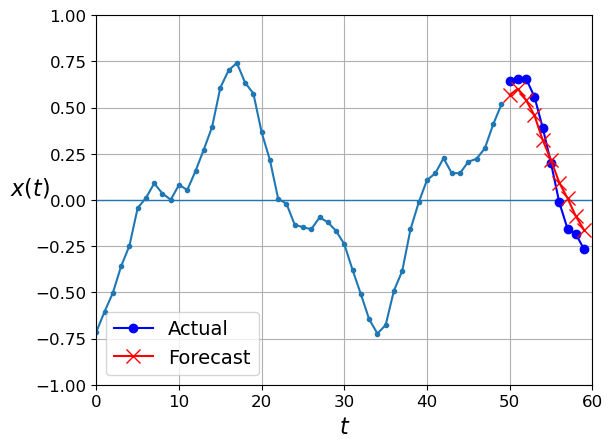

In [35]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

이제 타임 스텝마다 다음 10 스텝을 예측하는 RNN을 만들어 보겠습니다. 즉 타임 스텝 0에서 49까지를 기반으로 타임 스텝 50에서 59를 예측하는 것이 아니라, 타임 스텝 0에서 타임 스텝 1에서 10까지 예측하고 그다음 타임 스텝 1에서 타임 스텝 2에서 11까지 예측합니다. 마지막 타임 스텝에서는 타임 스텝 50에서 59까지 예측합니다. 이 모델은 인과 모델입니다. 어떤 타임 스텝에서 예측을 만들 때 과거 타임 스텝만 볼 수 있습니다.

In [36]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [37]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 29s 128ms/step - loss: 0.0482 - last_time_step_mse: 0.0374 - val_loss: 0.0380 - val_last_time_step_mse: 0.0257
Epoch 2/20
219/219 [==============================] - 28s 130ms/step - loss: 0.0365 - last_time_step_mse: 0.0237 - val_loss: 0.0377 - val_last_time_step_mse: 0.0279
Epoch 3/20
219/219 [==============================] - 28s 128ms/step - loss: 0.0310 - last_time_step_mse: 0.0183 - val_loss: 0.0292 - val_last_time_step_mse: 0.0165
Epoch 4/20
219/219 [==============================] - 28s 130ms/step - loss: 0.0287 - last_time_step_mse: 0.0160 - val_loss: 0.0268 - val_last_time_step_mse: 0.0150
Epoch 5/20
219/219 [==============================] - 27s 122ms/step - loss: 0.0268 - last_time_step_mse: 0.0148 - val_loss: 0.0257 - val_last_time_step_mse: 0.0126
Epoch 6/20
219/219 [==============================] - 26s 120ms/step - loss: 0.0249 - last_time_step_mse: 0.0125 - val_loss: 0.0262 - val_last_time_step_mse: 0.0158
Epoch 7/20

In [39]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 354ms/step


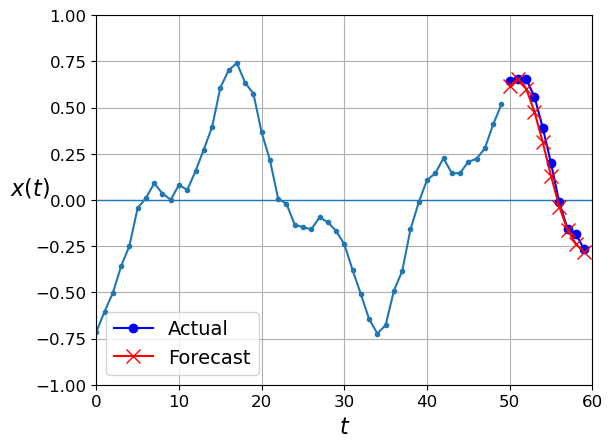

In [40]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# 배치 정규화를 사용한 심층 RNN

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 29s 126ms/step - loss: 0.2460 - last_time_step_mse: 0.2458 - val_loss: 0.0771 - val_last_time_step_mse: 0.0696
Epoch 2/20
219/219 [==============================] - 26s 120ms/step - loss: 0.0569 - last_time_step_mse: 0.0461 - val_loss: 0.0519 - val_last_time_step_mse: 0.0418
Epoch 3/20
219/219 [==============================] - 27s 121ms/step - loss: 0.0491 - last_time_step_mse: 0.0383 - val_loss: 0.0473 - val_last_time_step_mse: 0.0360
Epoch 4/20
219/219 [==============================] - 28s 127ms/step - loss: 0.0457 - last_time_step_mse: 0.0347 - val_loss: 0.0441 - val_last_time_step_mse: 0.0335
Epoch 5/20
219/219 [==============================] - 27s 124ms/step - loss: 0.0433 - last_time_step_mse: 0.0322 - val_loss: 0.0420 - val_last_time_step_mse: 0.0312
Epoch 6/20
219/219 [==============================] - 27s 124ms/step - loss: 0.0412 - last_time_step_mse: 0.0293 - val_loss: 0.0402 - val_last_time_step_mse: 0.0283
Epoch 7/20

# 층 정규화를 사용한 심층 RNN

In [42]:
from tensorflow.keras.layers import LayerNormalization

In [43]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 69s 296ms/step - loss: 0.1378 - last_time_step_mse: 0.1131 - val_loss: 0.0673 - val_last_time_step_mse: 0.0489
Epoch 2/20
219/219 [==============================] - 60s 275ms/step - loss: 0.0629 - last_time_step_mse: 0.0478 - val_loss: 0.0602 - val_last_time_step_mse: 0.0481
Epoch 3/20
219/219 [==============================] - 61s 279ms/step - loss: 0.0563 - last_time_step_mse: 0.0443 - val_loss: 0.0535 - val_last_time_step_mse: 0.0407
Epoch 4/20
219/219 [==============================] - 60s 272ms/step - loss: 0.0514 - last_time_step_mse: 0.0404 - val_loss: 0.0496 - val_last_time_step_mse: 0.0376
Epoch 5/20
219/219 [==============================] - 60s 274ms/step - loss: 0.0475 - last_time_step_mse: 0.0376 - val_loss: 0.0448 - val_last_time_step_mse: 0.0345
Epoch 6/20
219/219 [==============================] - 59s 270ms/step - loss: 0.0430 - last_time_step_mse: 0.0344 - val_loss: 0.0402 - val_last_time_step_mse: 0.0321
Epoch 7/20

# 사용자 정의 RNN 클래스 만들기

In [45]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 62s 279ms/step - loss: 0.1601 - last_time_step_mse: 0.1345 - val_loss: 0.0686 - val_last_time_step_mse: 0.0512
Epoch 2/20
219/219 [==============================] - 61s 280ms/step - loss: 0.0623 - last_time_step_mse: 0.0469 - val_loss: 0.0578 - val_last_time_step_mse: 0.0455
Epoch 3/20
219/219 [==============================] - 61s 280ms/step - loss: 0.0551 - last_time_step_mse: 0.0421 - val_loss: 0.0522 - val_last_time_step_mse: 0.0394
Epoch 4/20
219/219 [==============================] - 60s 275ms/step - loss: 0.0507 - last_time_step_mse: 0.0379 - val_loss: 0.0475 - val_last_time_step_mse: 0.0365
Epoch 5/20
219/219 [==============================] - 61s 277ms/step - loss: 0.0463 - last_time_step_mse: 0.0338 - val_loss: 0.0440 - val_last_time_step_mse: 0.0334
Epoch 6/20
219/219 [==============================] - 60s 274ms/step - loss: 0.0425 - last_time_step_mse: 0.0283 - val_loss: 0.0410 - val_last_time_step_mse: 0.0263
Epoch 7/20

# LSTM

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 13ms/step - loss: 0.0767 - last_time_step_mse: 0.0615 - val_loss: 0.0559 - val_last_time_step_mse: 0.0379
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0487 - last_time_step_mse: 0.0293 - val_loss: 0.0422 - val_last_time_step_mse: 0.0202
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0384 - last_time_step_mse: 0.0169 - val_loss: 0.0362 - val_last_time_step_mse: 0.0145
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0346 - last_time_step_mse: 0.0141 - val_loss: 0.0334 - val_last_time_step_mse: 0.0129
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0325 - last_time_step_mse: 0.0131 - val_loss: 0.0319 - val_last_time_step_mse: 0.0128
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0310 - last_time_step_mse: 0.0122 - val_loss: 0.0302 - val_last_time_step_mse: 0.0116
Epoch 7/20
219/219 [======

In [48]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0237 - last_time_step_mse: 0.0080


[0.023678423836827278, 0.007986770011484623]

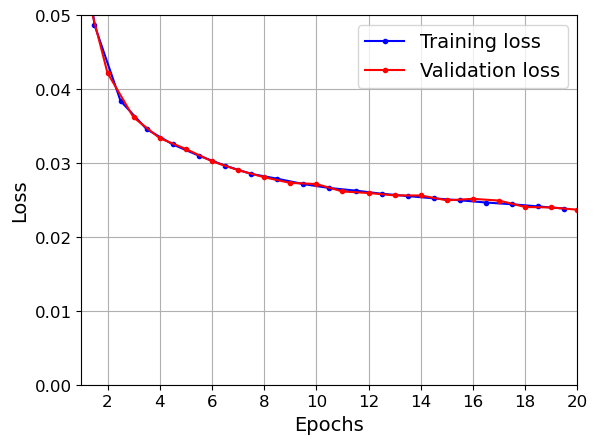

In [49]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [50]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 373ms/step


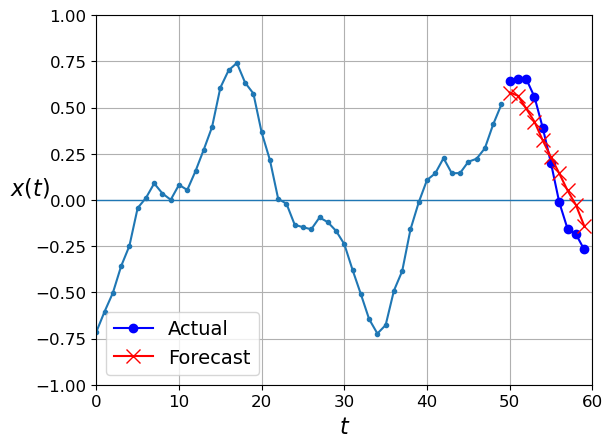

In [51]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRU

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 11ms/step - loss: 0.0737 - last_time_step_mse: 0.0650 - val_loss: 0.0522 - val_last_time_step_mse: 0.0409
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0477 - last_time_step_mse: 0.0367 - val_loss: 0.0446 - val_last_time_step_mse: 0.0333
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0431 - last_time_step_mse: 0.0317 - val_loss: 0.0412 - val_last_time_step_mse: 0.0294
Epoch 4/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0401 - last_time_step_mse: 0.0286 - val_loss: 0.0380 - val_last_time_step_mse: 0.0257
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0365 - last_time_step_mse: 0.0243 - val_loss: 0.0346 - val_last_time_step_mse: 0.0235
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0326 - last_time_step_mse: 0.0186 - val_loss: 0.0307 - val_last_time_step_mse: 0.0151
Epoch 7/20
219/219 [=======

In [53]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0233 - last_time_step_mse: 0.0091


[0.02333947829902172, 0.0091248769313097]

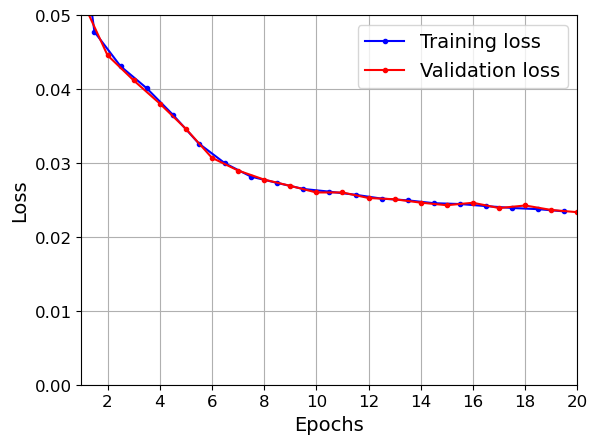

In [54]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [55]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 325ms/step


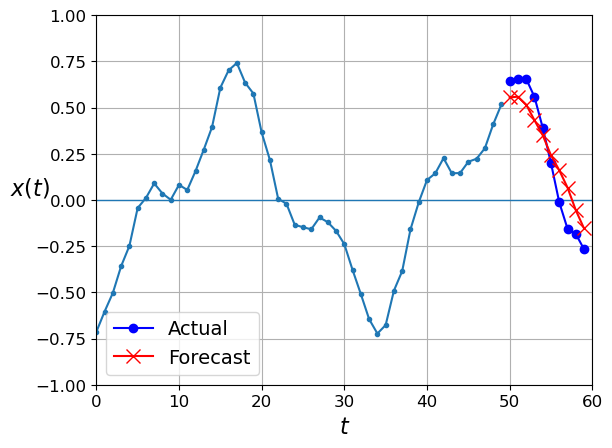

In [56]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## 1D 합성곱 층을 사용해 시퀀스 처리하기

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 10s 8ms/step - loss: 0.0704 - last_time_step_mse: 0.0623 - val_loss: 0.0496 - val_last_time_step_mse: 0.0408
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0398 - last_time_step_mse: 0.0315 - val_loss: 0.0322 - val_last_time_step_mse: 0.0237
Epoch 3/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0288 - last_time_step_mse: 0.0192 - val_loss: 0.0271 - val_last_time_step_mse: 0.0168
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0255 - last_time_step_mse: 0.0150 - val_loss: 0.0246 - val_last_time_step_mse: 0.0143
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0240 - last_time_step_mse: 0.0134 - val_loss: 0.0238 - val_last_time_step_mse: 0.0139
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0230 - last_time_step_mse: 0.0125 - val_loss: 0.0224 - val_last_time_step_mse: 0.0119
Epoch 7/20
219/219 [=======

## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0681 - last_time_step_mse: 0.0545 - val_loss: 0.0387 - val_last_time_step_mse: 0.0220
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0338 - last_time_step_mse: 0.0184 - val_loss: 0.0298 - val_last_time_step_mse: 0.0148
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0284 - last_time_step_mse: 0.0140 - val_loss: 0.0270 - val_last_time_step_mse: 0.0131
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0262 - last_time_step_mse: 0.0126 - val_loss: 0.0251 - val_last_time_step_mse: 0.0117
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0248 - last_time_step_mse: 0.0116 - val_loss: 0.0246 - val_last_time_step_mse: 0.0117
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0239 - last_time_step_mse: 0.0110 - val_loss: 0.0235 - val_last_time_step_mse: 0.0107
Epoch 7/20
219/219 [========

다음은 논문에 정의된 원본 WaveNet입니다: ReLU 대신에 GatedActivationUnit과 스킵 연결을 사용합니다. 또한 점점 더 시퀀스가 짧아지는 것을 피하기 위해 왼쪽에 0으로 패딩합니다:

In [59]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [60]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [61]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [62]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 3s 9ms/step - loss: 0.1298 - last_time_step_mse: 0.1257 - val_loss: 0.1228 - val_last_time_step_mse: 0.1197
Epoch 2/2
219/219 [==============================] - 2s 9ms/step - loss: 0.1222 - last_time_step_mse: 0.1177 - val_loss: 0.1218 - val_last_time_step_mse: 0.1189


이 장에서 RNN의 기초 사항을 살펴 보았고 RNN을 사용해 시퀀스(소위 시계열)을 처리했습니다. CNN을 포함하여 시퀀스를 처리하는 다른 방법도 알아 보았습니다. 다음 장에서는 RNN을 자연어 처리에 적용해 보겠습니다. 그리고 RNN에 대해 더 자세히 배워 보겠습니다(양방향 RNN, 상태가 있는 RNN과 상태가 없는 RNN, 인코더-디코더, 어텐션을 사용한 인코더-디코더). 또한 어텐션만 사용하는 구조인 트랜스포머도 살펴 보겠습니다.